# SLAM based on USIP keypoints

Association between keypoints:
* Only between consequtive frames (no loop-closures)
* Based on distance thresholding
* Initial guess for matching is done by A-LOAM odometry prior estimation 

In [1]:
import open3d as o3d
import numpy as np
import os
import mrob
from scipy import spatial
import statistics

In [2]:
MAP = '00'
DIST_THRESHOLD = 0.06

LOOP_CLOSURE_DIST = 20
LOOP_CLOSURE_LAST_FRAMES_CNT = 5

FPFH_THRESHOLD = 100
NORMAL_RADIUS = 1
NORMAL_NN = 100
FEATURE_RADIUS = 5
FEATURE_NN = 100

## Utils

In [3]:
# Returns numpy presentation of point cloud
def get_point_cloud(path, is_keypoint=False):
    pcd_np = None
    if path.endswith('npy'):
        pcd_np = np.load(path)
    elif path.endswith('bin'):
        if is_keypoint:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 3)
        else:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 4)[:, :3]
    else:
        raise Exception('Point cloud format is not supported')
    
    return pcd_np


# Returns open3d point cloud representation
def get_pcd_from_numpy(np_pcd, color=[0, 0, 1]):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd)
    pcd.paint_uniform_color(color)
    return pcd

def transform_array(np_array, T):
    return mrob.geometry.SE3(T).transform_array(np_array)

def quat_to_transform(d):
    quat = np.array(d[3:7], dtype='float64')
    T = np.eye(4, dtype='float64')
    T[:3, :3] =  mrob.geometry.quat_to_so3(quat)
    T[0, 3] = d[0]
    T[1, 3] = d[1]
    T[2, 3] = d[2]
    return T

# set1 -- set of keypoints from pcd1
# set2 -- set of keypoints from pcd2
# T - transformation between pcd1 and pcd2
# return -- correspondes between points based on the distance thresholding
def find_correspondences(set1, set2, T):
    corresp = []
    set2_aligned = transform_array(set2, T)
    set2_aligned_tree = spatial.KDTree(set2_aligned)
    picked_flag = np.zeros(set2.shape[0])
    for i in range(set1.shape[0]):
        dist, ind = set2_aligned_tree.query(set1[i], 1)
        if picked_flag[ind] == 0 and dist / np.linalg.norm(set2[ind]) < DIST_THRESHOLD:
            corresp.append((i, ind))
            picked_flag[ind] = 1
    return corresp

def get_keypoints_features(np_pcd, np_keypoints):
    np_combined = np.concatenate((np_pcd, np_keypoints))

    pcd_combined = get_pcd_from_numpy(np_combined)
    pcd_combined.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=NORMAL_RADIUS, max_nn=NORMAL_NN))

    pcd_fpfh = o3d.registration.compute_fpfh_feature(pcd_combined
                    , o3d.geometry.KDTreeSearchParamHybrid(radius=FEATURE_RADIUS, max_nn=FEATURE_NN))
    
    pcd_fpfh.data = pcd_fpfh.data[:, -np_keypoints.shape[0]:]
    return pcd_fpfh

## Load GT

In [4]:
import csv

kitti_odometry_path = '../../data_odometry_poses_USIP/dataset/poses/' + MAP + '.txt'
odometry = []
with open(kitti_odometry_path, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=' ')
    for row in odometry_reader:
        row = [float(i) for i in row]
        odometry.append(np.array(row).reshape(3, 4))

In [5]:
path_x = []
path_y = []
for matrix in odometry:
    path_x.append(float(matrix[0, 3]))
    path_y.append(float(matrix[2, 3]))

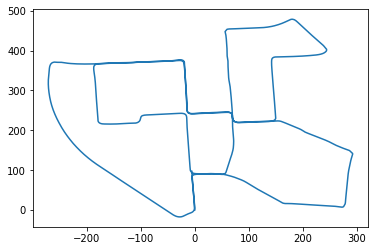

In [6]:
import matplotlib.pyplot as plt

plt.plot(path_x, path_y)
plt.show()

## Keypoints extraction

In [7]:
loam_eval_path = '../../aloam_eval/' + MAP + '.txt' 

In [8]:
loam_odom_x = []
loam_odom_y = []
loam_odom = []
with open(loam_eval_path, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=',')
    for row in odometry_reader:
        row = [float(i) for i in row]
        loam_odom.append(row)
        loam_odom_x.append(-row[1])
        loam_odom_y.append(row[0])

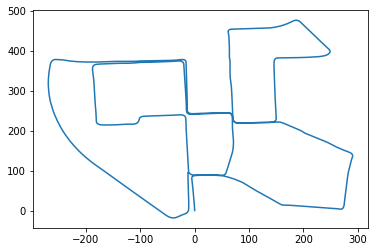

In [9]:
import matplotlib.pyplot as plt

plt.plot(loam_odom_x, loam_odom_y)
plt.show()

## Simple SLAM class

40
19 42 30.0


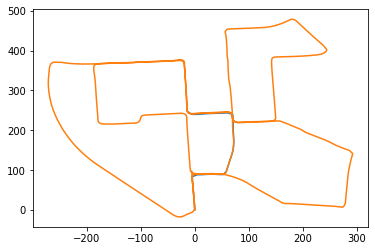

17 28
18 34
12 28
22 34
16 35
17 35
16 35
22 39
16 31
23 36
19 34
21 35
8 19
12 31
13 25
18 34
12 35
12 25
7 25


In [ ]:
import collections
from IPython.display import clear_output

class UsipSLAM:
    def __init__(self):
        self.poses_id = []
        self.prev_keypoints = None
        self.prev_fpfh = None
        self.graph = mrob.fgraph.FGraph()
        self.last_pos = np.eye(4)
        self.corres_cnt = []

    # T -- transformation from LOAM
    # keypoints -- keypoints associated with considered pcd
    def add_state(self, delta_T, keypoints, pcd):
        self.graph.print(True)
        T = delta_T @ self.last_pos
        if not self.poses_id:
            # Add anchor pose
            p = self.graph.add_node_pose_3d(mrob.geometry.SE3(np.eye(4)))
            self.graph.add_factor_1pose_3d(mrob.geometry.SE3(), p, 1e6 * np.eye(6))
            self.poses_id.append(p)
            
            # Add keypoints to anchor pose
            self.prev_keypoints = keypoints
            self.prev_fpfh = get_keypoints_features(pcd, keypoints)
        else:
            # Add non-anchor pose
            p = self.graph.add_node_pose_3d(mrob.geometry.SE3(T))
            self.graph.add_factor_2poses_3d(mrob.geometry.SE3(delta_T), p, self.poses_id[-1], np.eye(6))
            self.poses_id.append(p)
            
            corresp = find_correspondences(self.prev_keypoints, keypoints, delta_T)
            self.corres_cnt.append(len(corresp))
            fpfh = get_keypoints_features(pcd, keypoints)
            # Add factors to existing landmarks
            filtered_out_cnt = 0
            for pair in corresp:
                if np.linalg.norm(self.prev_fpfh.data[:, pair[0]] - fpfh.data[:, pair[1]]) < FPFH_THRESHOLD:
                    l = self.graph.add_node_landmark_3d(np.zeros(3))                
                    self.graph.add_factor_1pose_1landmark_3d(keypoints[pair[1]], p, l, np.eye(3))
                    self.graph.add_factor_1pose_1landmark_3d(self.prev_keypoints[pair[0]], self.poses_id[-2], 
                                                         l, np.eye(3))
                    filtered_out_cnt += 1
            
            print(filtered_out_cnt, len(corresp))
            
            self.graph.solve(mrob.fgraph.LM)
            
            self.prev_keypoints = keypoints
            self.last_pos = self.graph.get_estimated_state()[self.poses_id[-1]]
            self.prev_fpfh = fpfh

    
    def check_loop_closure(self):
        if len(self.poses_id) > LOOP_CLOSURE_LAST_FRAMES_CNT:
            state = self.graph.get_estimated_state()
            poses = [state[i][:3, 3] for i in self.poses_id]
            distances = np.linalg.norm(poses - poses[-1], axis=1)[:-LOOP_CLOSURE_LAST_FRAMES_CNT]
            min_dist_ind = np.argmin(distances)
            if distances[min_dist_ind] < LOOP_CLOSURE_DIST:
                return True, self.poses_id[min_dist_ind]
        
        return False, None

        
    def get_poses(self):
        state = self.graph.get_estimated_state()
        return [state[i][:3, 3] for i in self.poses_id]
    
    def update_states(self):
        state = self.graph.get_estimated_state()        
        self.last_pos = state[self.poses_id[-1]]

        
calib_T = np.array([4.276802385584e-04, -9.999672484946e-01, -8.084491683471e-03, -1.198459927713e-02, 
                    -7.210626507497e-03, 8.081198471645e-03, -9.999413164504e-01, -5.403984729748e-02, 
                    9.999738645903e-01, 4.859485810390e-04, -7.206933692422e-03, -2.921968648686e-01,
                   0, 0, 0, 1]).reshape(4, 4)
dT = np.linalg.inv(calib_T)
kitti_keypoints_path = '../../keypoints_kitti_16_2/' + MAP + '/'
kitti_pcds_path = '/home/anastasiya/data/data_odometry_velodyne/dataset/sequences/00/velodyne/'

keypoint_files = os.listdir(kitti_keypoints_path)
keypoint_files.sort()
slam = UsipSLAM()
prev_T = np.eye(4)
for i, filename in enumerate(keypoint_files[:-1]):
    idx = filename.split('.')[0]
    keypoints = transform_array(get_point_cloud(kitti_keypoints_path + idx + '.bin', is_keypoint=True), dT)
    pcd_np = get_point_cloud(kitti_pcds_path + idx + '.bin', is_keypoint=False)
    q_t = loam_odom[int(idx)]
    T_t = quat_to_transform(q_t)
    slam.add_state(np.linalg.inv(prev_T) @ T_t, keypoints, pcd_np)
    prev_T = T_t
    
    if (i > 0 and i % 20 == 0):
        poses = slam.get_poses()
        clear_output(True)
        print(i)
        print(min(slam.corres_cnt), max(slam.corres_cnt), statistics.median(slam.corres_cnt))
        pos_x = []
        pos_y = []
        for i in range(len(poses)):
            pos_x.append(-poses[i][1])
            pos_y.append(poses[i][0])
    
        plt.plot(pos_x, pos_y)
        plt.plot(path_x, path_y)
        plt.show()

In [ ]:
poses = slam.get_poses()
pos_x = []
pos_y = []
for i in range(len(poses)):
    pos_x.append(-poses[i][1])
    pos_y.append(poses[i][0])
    
plt.plot(pos_x, pos_y, label='simple SLAM')
plt.plot(path_x, path_y, label='GT')
# plt.plot(loam_odom_x, loam_odom_y, label='LOAM')
plt.legend()
plt.savefig(MAP + '_res.png')